<a href="https://colab.research.google.com/github/Vaycold/Python_ML/blob/main/Reco_Algo/Embedding%26Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal :
  - Large-scale에서 적용 가능한 추천시스템 구조 이해
  - Word2vec 기반 임베딩
  - EDA에서 도출되는 다양한 INSIGHT
  - [Point-Wise] 모델링
  - Factorization Machine 알고리즘
  - ML에 활용할 수 있는 데이터 변환
  - 추천결과 평가방법

### Word2Vec

   - 임베딩 방법론 중 가장 대중적이고 성능이 좋은 방법
   - 같은 문장 내 혹은 비슷한 위치에 등장하는 단어들을 유사한 의미를 가지고 있을 것이라는 가정
   - 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음.
   - Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.

In [16]:
import pandas as pd

# rating dataset

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df  = pd.io.parsers.read_csv(rating_url, names = ['user_id', 'movie_id', 'rating','time'], delimiter = '::',engine='python')

# movies dataset

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df  =  pd.io.parsers.read_csv(movie_url, names = [ 'movie_id', 'title','genre'], delimiter = '::',engine='python', encoding='ISO-8859-1')

# user dataset

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df  = pd.io.parsers.read_csv(user_url, names = ['user_id', 'gender', 'age','accupation','zipcode'], delimiter = '::',engine='python')

In [9]:
# 시간에 따라 사용자별 시청 목록 추출
def get_movie_list_sory_by_time(x) :
    return x.sort_values(['time'])['movie_id'].tolist()


user_watch_list = rating_df.groupby('user_id')[['movie_id','time']].apply(
    lambda x : get_movie_list_sory_by_time(x)
) # 여기서 movie_id, time은 apply의 영향을 받는 column 들임.

In [11]:
user_watch_list

user_id
1       [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2       [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3       [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
4       [1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...
5       [2717, 919, 908, 356, 1250, 2188, 2858, 1127, ...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 1961, 2019, 573, 3111, 3505, ...
Length: 6040, dtype: object

In [12]:
rating_df['movie_id'].value_counts()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3323       1
624        1
763        1
2484       1
133        1
Name: movie_id, Length: 3706, dtype: int64

In [17]:
# 영화의 개봉년도 feature 생성
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
movie_df['released_year_area'] = movie_df['title'].apply(
    lambda x : x[-5:-2] + '0'
)
movie_df.head()

,movie_id,title,genre,released_year_area
0,1,Toy Story (1995),Animation|Children's|Comedy,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990
2,3,Grumpier Old Men (1995),Comedy|Romance,1990
3,4,Waiting to Exhale (1995),Comedy|Drama,1990
4,5,Father of the Bride Part II (1995),Comedy,1990


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


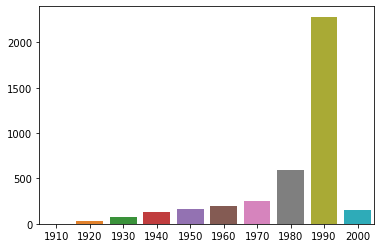

In [21]:
import seaborn as sns
released_year_area = movie_df['released_year_area'].value_counts().sort_index() # sort_index를 함으로써 시간순으로 볼 수 있게 됨.
sns.barplot(released_year_area.index, released_year_area.values)

In [22]:
# 영화 장르 feature 생성
movie_df['genre'].value_counts()

Drama                            843
Comedy                           521
Horror                           178
Comedy|Drama                     162
Comedy|Romance                   142
                                ... 
Action|Comedy|Crime                1
Action|Drama|Sci-Fi|Thriller       1
Romance|Western                    1
Adventure|Animation|Film-Noir      1
Adventure|Children's|Romance       1
Name: genre, Length: 301, dtype: int64

In [23]:
movie_df['main_genre'] = movie_df['genre'].apply(lambda x : x.split("|")[0])
movie_df['main_genre'].value_counts()

Drama          1176
Comedy         1024
Action          503
Horror          262
Adventure       155
Crime           131
Documentary     123
Thriller        101
Animation        90
Children's       89
Romance          50
Sci-Fi           46
Mystery          36
Western          33
Film-Noir        25
Musical          25
War              12
Fantasy           2
Name: main_genre, dtype: int64

In [24]:
# movie2vec 학습
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [34]:
movie_meta_dict = movie_df.set_index('movie_id')[['released_year_area','main_genre']]
movie_meta_dict.head(2)

,released_year_area,main_genre
movie_id,,
1,1990,Animation
2,1990,Adventure


In [35]:
movie_meta_dict = movie_meta_dict.to_dict()

In [38]:
movie_meta_dict

{'main_genre': {1: 'Animation',
  2: 'Adventure',
  3: 'Comedy',
  4: 'Comedy',
  5: 'Comedy',
  6: 'Action',
  7: 'Comedy',
  8: 'Adventure',
  9: 'Action',
  10: 'Action',
  11: 'Comedy',
  12: 'Comedy',
  13: 'Animation',
  14: 'Drama',
  15: 'Action',
  16: 'Drama',
  17: 'Drama',
  18: 'Thriller',
  19: 'Comedy',
  20: 'Action',
  21: 'Action',
  22: 'Crime',
  23: 'Thriller',
  24: 'Drama',
  25: 'Drama',
  26: 'Drama',
  27: 'Drama',
  28: 'Romance',
  29: 'Adventure',
  30: 'Drama',
  31: 'Drama',
  32: 'Drama',
  33: 'Adventure',
  34: "Children's",
  35: 'Drama',
  36: 'Drama',
  37: 'Documentary',
  38: 'Comedy',
  39: 'Comedy',
  40: 'Drama',
  41: 'Drama',
  42: 'Action',
  43: 'Drama',
  44: 'Action',
  45: 'Comedy',
  46: 'Drama',
  47: 'Crime',
  48: 'Animation',
  49: 'Drama',
  50: 'Crime',
  51: 'Action',
  52: 'Comedy',
  53: 'Drama',
  54: "Children's",
  55: 'Drama',
  56: 'Adventure',
  57: 'Drama',
  58: 'Drama',
  59: 'Drama',
  60: 'Adventure',
  61: 'Drama',


In [43]:
user_watch_list

user_id
1       [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2       [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3       [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
4       [1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...
5       [2717, 919, 908, 356, 1250, 2188, 2858, 1127, ...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 1961, 2019, 573, 3111, 3505, ...
Length: 6040, dtype: object

In [50]:
'''
ex ) 
    역시 성공은 고난을 동반  
 -> [역시, 성공, 고난, 동반]
  = [movie_id :1, genre: drama, ...]
'''
movie2vec_dataset = []
for movie_list in user_watch_list :
    meta_list = []
    for movie_id in movie_list :
        word_meta_1 = 'movie_id:' + str(movie_id)
        word_meta_2 = 'year:' + movie_meta_dict['released_year_area'][movie_id]
        word_meta_3 = 'genre:' + movie_meta_dict['main_genre'][movie_id]
        meta_list.append(word_meta_1)
        meta_list.append(word_meta_2)
        meta_list.append(word_meta_3)
    movie2vec_dataset.append(meta_list)

In [51]:
str(movie2vec_dataset)[:300]

"[['movie_id:3186', 'year:1990', 'genre:Drama', 'movie_id:1721', 'year:1990', 'genre:Drama', 'movie_id:1022', 'year:1950', 'genre:Animation', 'movie_id:1270', 'year:1980', 'genre:Comedy', 'movie_id:2340', 'year:1990', 'genre:Romance', 'movie_id:1836', 'year:1990', 'genre:Drama', 'movie_id:3408', 'yea"

In [52]:
!pip install gensim

In [53]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 size = 100,
                 window = 6,          # 주변 word의 window                          : 주변의 단어를 몇개 볼 것이냐
                 sg = 1,              # SKIP-gram OR Cbow                           : skip-gram 방식을 쓰겠다 = 1  
                 hs = 0,              # hierachical softmax OR negative sampling    : negative sampling을 쓰겠다 = 0 
                 negative = 20,       # negative sampling parameter
                 min_count = 1,       # word의 등장 최소 횟수
                 iter = 20)

In [54]:
model.wv.most_similar('movie_id:1', topn=5)

[('movie_id:1223', 0.8326447010040283),
 ('movie_id:3429', 0.7352192401885986),
 ('movie_id:2324', 0.7042630910873413),
 ('movie_id:2289', 0.6919315457344055),
 ('movie_id:3114', 0.6743910908699036)]

In [56]:
movie_df[movie_df['movie_id'].isin([1223,3429,2324,2289,3114])]

,movie_id,title,genre,released_year_area,main_genre
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1990,Animation
2220,2289,"Player, The (1992)",Comedy|Drama,1990,Comedy
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1990,Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1990,Animation
3360,3429,Creature Comforts (1990),Animation|Comedy,1990,Animation


In [59]:
movie_df.head(4)

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy


In [ ]:
# movie2vec 모델로 item2item 후보군 생성

item2item = {}
k = 10 # 연관영화 추출 갯수
not_in_count = 0
for movie_id in movie_df['movie_id'].values :
    item2item[movie_id] = []
    try :
        sim_list = model.wv.most_similar('movie_id:'+str(movie_id), topn = k+10)
        for movie_tup in sim_list :
            tup_info = movie_tup[0].split(":")
            if (tub_info[0] == 'movie_id') and (len(item2item[movie_id]) <10) :
                item2item[movie_id].append(tup_info[1])
    except :
        not_in_count += 1
        print(f'word {str(movie_id)} not in vocabulary')

In [ ]:
k = 10 # 연관영화 추출 갯수
not_in_count = 0
for movie_id in movie_df['movie_id'].values:
  item2item[movie_id] = []
  try:
    sim_list = model.wv.most_similar("movie_id:" + str(movie_id), topn=k+10)
    for movie_tup in sim_list:
      tup_info = movie_tup[0].split(":")
      if (tup_info[0] == "movie_id") and (len(item2item[movie_id]) < 10):
        item2item[movie_id].append(tup_info[1])
  except:
    not_in_count += 1
    print("word", str(movie_id) ,"not in vocabulary")

In [71]:
not_in_count

177

In [66]:
item2item

{1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: [],
 101: [],
 102: [],
 103: [],
 104: [],
 105: [],
 106: [],
 107: [],
 108: [],
 109: [],
 110: [],
 111: [],
 112: [

In [67]:
not_in_count

3883